In [1]:
import sys
import os

# UPDATE THIS LINE to match your actual file path
sys.path.append('/hdd3/dongen/Desktop/darkphoton') 

import torch
import numpy as np
import random
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score

# These imports should now work because python looks inside 'darkphoton'
from darkphotondataset import DarkPhotonDataset
from transforms import GraphFilter
from matplotlib import pyplot as plt
from models.model import Transformer  # This looks for ./models/model.py
from utils import LoadBalancingLoss
from train.train import evaluate


/hdd3/dongen/.conda/envs/dongendark/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ---- CONFIGURATION ----
input_size = 4
hidden_size = 80
encoding_size = 4
g_norm = False
heads = 2
num_xprtz = 6
xprt_size = 30
k = 2
dropout_encoder = 0.2
layers = 2
output_size = 2
w_load = 1
batchsize = 256
seed = 3958239256
#model_ckpt_path = '/home/dongen/darkphoton/train/results/4804False263020.222125680450.10.002Trueprova/final_model.pt'
seeds_to_test = [seed + i for i in range(50)]

In [3]:
def set_seed_everything(seed):
    """Set seed for reproducibility across all libraries"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    try:
        torch.use_deterministic_algorithms(True, warn_only=True)
    except AttributeError:
        # For older PyTorch versions
        pass

set_seed_everything(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset_root = '/hdd3/dongen/Desktop/darkphoton/train/data'
os.makedirs(dataset_root, exist_ok=True)

# ---- LOAD DATA ----
graph_filter = GraphFilter(min_num_nodes=2)
dataset = DarkPhotonDataset(
    root=dataset_root,
    subset=1.0,
    url="https://cernbox.cern.ch/s/PYurUUzcNdXEGpz/download",
    pre_filter=graph_filter,
    pre_transform=None,
    post_filter=None,
    verbose=True
)

# Function to compute width (from dataset_statistics.ipynb)
def compute_width(x):
    """
    Compute width (max ΔR) for a graph
    x: tensor of shape [num_nodes, 4] with [layer, eta, phi, energy]
    """
    layer = x[:, 0]
    widths = []
    for l in range(4):
        mask = (layer == l)
        coords = x[mask][:, 1:3]  # [eta, phi]
        if coords.size(0) < 2:
            continue
        diff = coords.unsqueeze(0) - coords.unsqueeze(1)
        dR = torch.norm(diff, dim=-1)
        max_dR = dR.max().item()
        widths.append(max_dR)
    width = max(widths) if widths else 0.0
    return width

# Filter dataset to keep only graphs with width > 0
dataset_nonzero_width = [data for data in dataset if compute_width(data.x) > 0]
print(f"Original dataset size: {len(dataset)}")
print(f"Filtered dataset (width > 0): {len(dataset_nonzero_width)}")

# Use dataset_nonzero_width for training instead of dataset
dataset = dataset_nonzero_width

trainset, testset = train_test_split(dataset, test_size=0.2)
generator = torch.Generator()
generator.manual_seed(seed)
test_loader = DataLoader(testset, batch_size=batchsize, shuffle=False, generator=generator, worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id))
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, generator=generator, worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id))


Loaded dataset containing subset of 1.0
Original dataset size: 99602
Filtered dataset (width > 0): 93927


In [4]:
!pip install tabulate

In [5]:
from collections import Counter
import pandas as pd
from tabulate import tabulate



# Optional display settings (not necessary for image generation)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", None)

def summarize_graph_node_counts_as_image(graphs, name="Dataset", save_path=None):
    node_counts = [data.x.size(0) for data in graphs]
    count_summary = Counter(node_counts)
    
    df = pd.DataFrame(sorted(count_summary.items()), columns=['# Nodes in Graph', f'# Graphs in {name}'])
    
    # Create matplotlib figure with height scaled by number of rows
    fig, ax = plt.subplots(figsize=(8, max(2, len(df) * 0.25)))
    ax.axis('off')  # Hide axes
    
    # Create table
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))
    
    plt.title(f"Summary for {name}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Table image saved to {save_path}")
    else:
        plt.show()

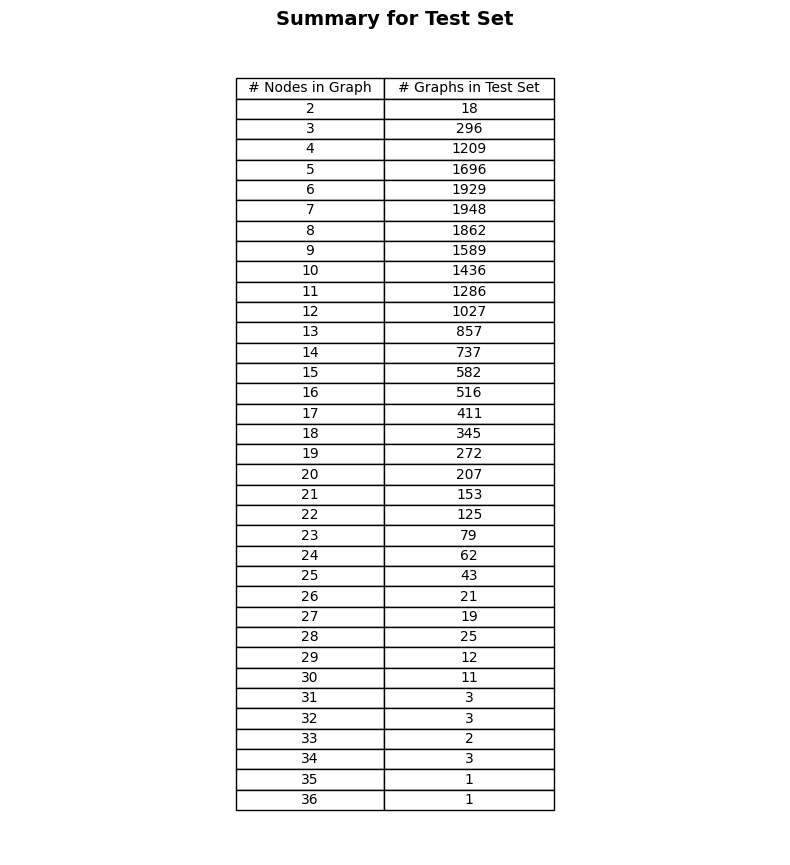

In [6]:
summarize_graph_node_counts_as_image(testset, name="Test Set")

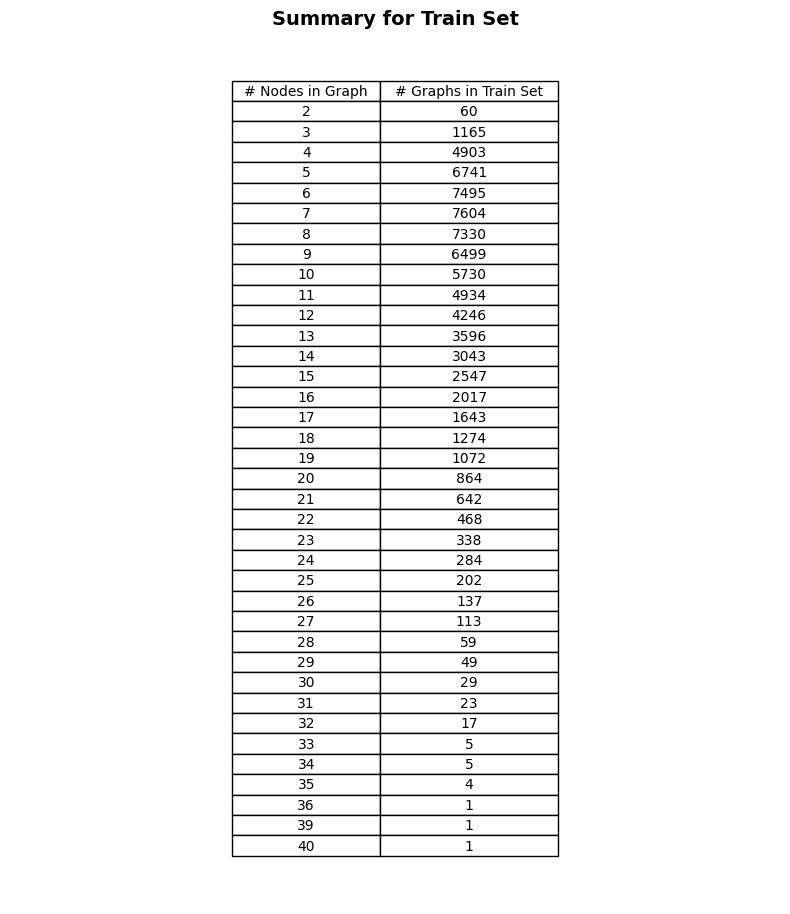

In [7]:
summarize_graph_node_counts_as_image(trainset, name="Train Set")

In [8]:
trainset[0]

Data(x=[8, 4], edge_index=[2, 56], edge_attr=[56, 1], y=[1])

In [9]:
dataset[20].x[:, 0]

tensor([0., 0., 1., 2., 2.])

In [10]:
import torch
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

def summarize_single_layer_graphs(graphs, name="Dataset"):
    """
    Count how many graphs have all nodes in a single layer.
    Returns a dictionary with layer index as key and count as value.
    """
    single_layer_counts = Counter()
    total_single_layer = 0
    
    for data in graphs:
        layers = data.x[:, 0]  # Extract layer information
        unique_layers = torch.unique(layers)
        
        # Check if all nodes are in a single layer
        if len(unique_layers) == 1:
            layer_id = int(unique_layers[0].item())
            single_layer_counts[layer_id] += 1
            total_single_layer += 1
    
    # Create summary
    print(f"\n{'='*60}")
    print(f"Single-Layer Graph Summary for {name}")
    print(f"{'='*60}")
    print(f"Total graphs: {len(graphs)}")
    print(f"Graphs with all nodes in one layer: {total_single_layer}")
    print(f"Percentage: {100 * total_single_layer / len(graphs):.2f}%")
    print(f"\nBreakdown by layer:")
    
    for layer in range(4):
        count = single_layer_counts.get(layer, 0)
        pct = 100 * count / len(graphs) if len(graphs) > 0 else 0
        print(f"  Layer {layer}: {count} graphs ({pct:.2f}%)")
    print(f"{'='*60}\n")
    
    # Create a visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Pie chart: single-layer vs multi-layer
    multi_layer_count = len(graphs) - total_single_layer
    ax1.pie(
        [total_single_layer, multi_layer_count],
        labels=['Single-layer graphs', 'Multi-layer graphs'],
        autopct='%1.1f%%',
        colors=['#ff9999', '#66b3ff'],
        startangle=90
    )
    ax1.set_title(f'Graph Distribution in {name}')
    
    # Bar chart: breakdown by layer
    layers = list(range(4))
    counts = [single_layer_counts.get(i, 0) for i in layers]
    ax2.bar(layers, counts, color=['red', 'green', 'blue', 'orange'])
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Number of Single-Layer Graphs')
    ax2.set_title('Single-Layer Graphs by Layer')
    ax2.set_xticks(layers)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'total_graphs': len(graphs),
        'single_layer_total': total_single_layer,
        'single_layer_by_layer': dict(single_layer_counts),
        'multi_layer': multi_layer_count
    }


Single-Layer Graph Summary for Train Set
Total graphs: 75141
Graphs with all nodes in one layer: 166
Percentage: 0.22%

Breakdown by layer:
  Layer 0: 125 graphs (0.17%)
  Layer 1: 13 graphs (0.02%)
  Layer 2: 27 graphs (0.04%)
  Layer 3: 1 graphs (0.00%)



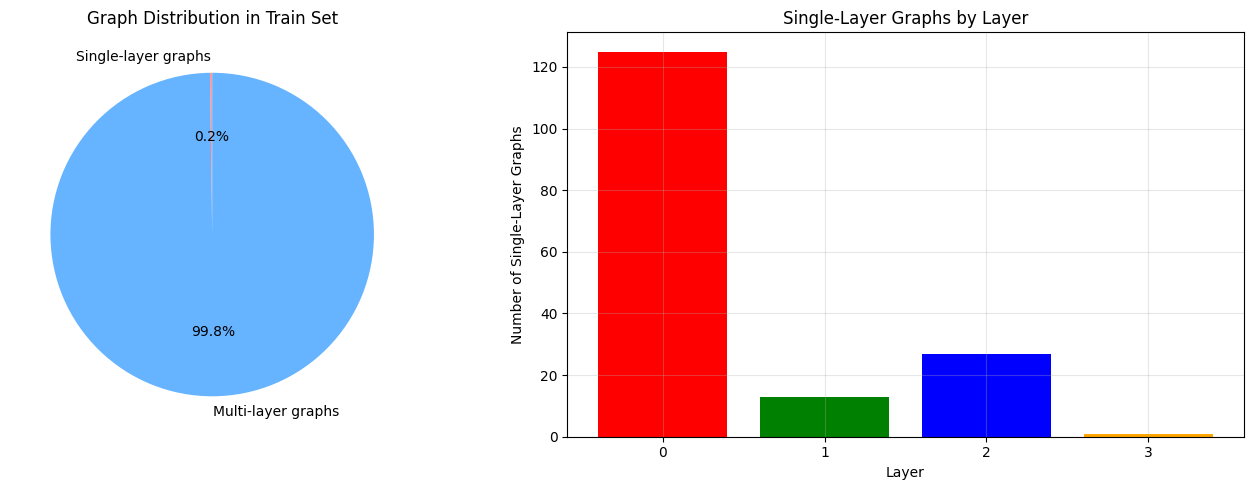


Single-Layer Graph Summary for Test Set
Total graphs: 18786
Graphs with all nodes in one layer: 46
Percentage: 0.24%

Breakdown by layer:
  Layer 0: 36 graphs (0.19%)
  Layer 1: 3 graphs (0.02%)
  Layer 2: 7 graphs (0.04%)
  Layer 3: 0 graphs (0.00%)



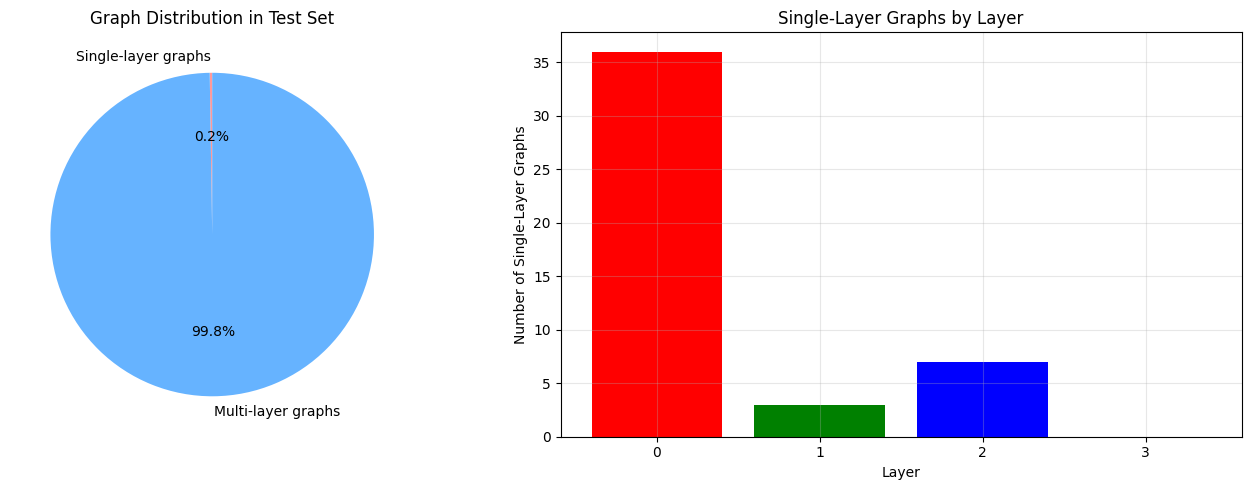

In [11]:
# Analyze single-layer graphs in train and test sets
train_single_layer_stats = summarize_single_layer_graphs(trainset, name="Train Set")
test_single_layer_stats = summarize_single_layer_graphs(testset, name="Test Set")

In [12]:
import torch
import matplotlib.pyplot as plt

def compute_graph_quantities(x):
    eta = x[:, 1]
    phi = x[:, 2]
    energy = x[:, 3]
    layer = x[:, 0]

    # 2. Eratio
    layer0_energy = energy[layer == 0].sum()
    total_energy = energy.sum()
    eratio = (layer0_energy / total_energy).item() if total_energy > 0 else 0.0

    # 3. Width
    widths = []
    for l in range(4):
        mask = (layer == l)
        coords = x[mask][:, 1:3]  # [eta, phi]
        if coords.size(0) < 2:
            continue
        diff = coords.unsqueeze(0) - coords.unsqueeze(1)
        dR = torch.norm(diff, dim=-1)
        max_dR = dR.max().item()
        widths.append(max_dR)
    width = max(widths) if widths else 0.0

    return eratio, width


In [13]:
# Lists for class 0 and class 1
eratio_class0, width_class0 = [], []
eratio_class1, width_class1 = [], []

for data in testset:
    x = data.x
    label = data.y.item()  # assuming data.y is scalar (0 or 1)
    eratio, width = compute_graph_quantities(x)

    if label == 0:
        eratio_class0.append(eratio)
        width_class0.append(width)
    elif label == 1:
        eratio_class1.append(eratio)
        width_class1.append(width)


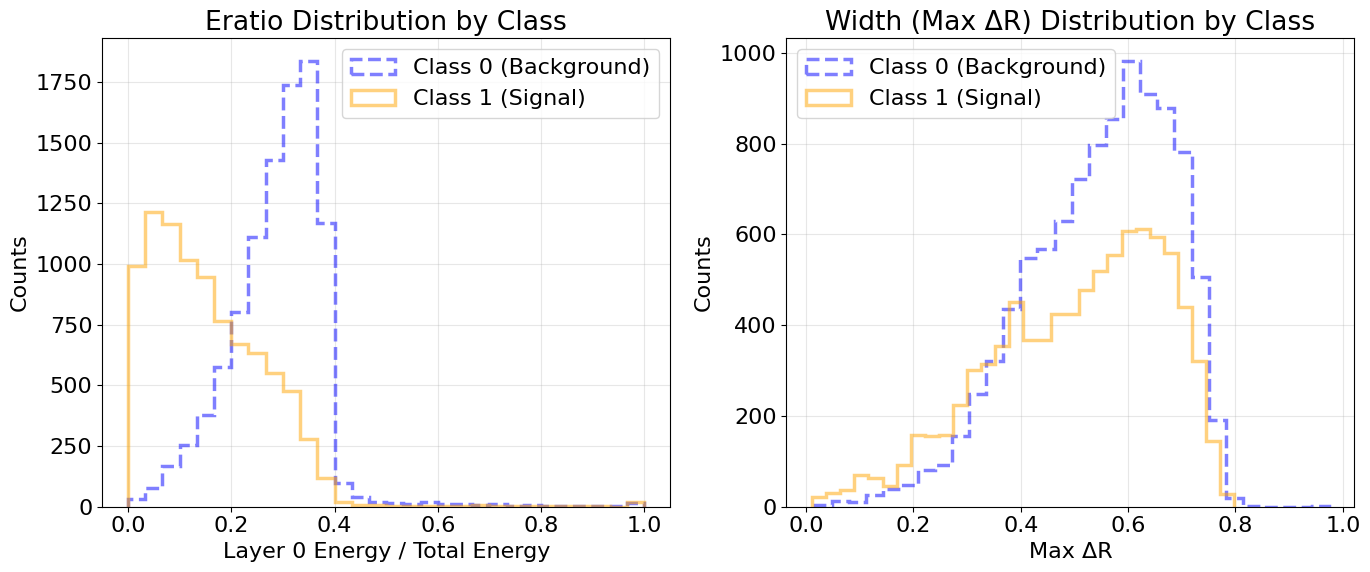

In [14]:
import matplotlib.pyplot as plt

plt.rc('font', size=16)
plt.figure(figsize=(14, 6))

# Eratio plot
plt.subplot(1, 2, 1)
plt.hist(eratio_class0, bins=30, color='blue', alpha=0.5, label='Class 0 (Background)', histtype='step', linewidth=2.5, linestyle='--')
plt.hist(eratio_class1, bins=30, color='orange', alpha=0.5, label='Class 1 (Signal)', histtype='step', linewidth=2.5, linestyle='-')
plt.title("Eratio Distribution by Class")
plt.xlabel("Layer 0 Energy / Total Energy")
plt.ylabel("Counts")
plt.legend()
plt.grid(True, alpha=0.3)

# Width plot
plt.subplot(1, 2, 2)
plt.hist(width_class0, bins=30, color='blue', alpha=0.5, label='Class 0 (Background)', histtype='step', linewidth=2.5, linestyle='--')
plt.hist(width_class1, bins=30, color='orange', alpha=0.5, label='Class 1 (Signal)', histtype='step', linewidth=2.5, linestyle='-')
plt.title("Width (Max ΔR) Distribution by Class")
plt.xlabel("Max ΔR")
plt.ylabel("Counts")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("class_comparison.pdf")
plt.show()


Analisi grafi con ΔR = 0

Class 0 (Background):
  Grafi con ΔR = 0: 0/9864 (0.00%)
  Grafi con ΔR > 0: 9864/9864 (100.00%)

Class 1 (Signal):
  Grafi con ΔR = 0: 0/8922 (0.00%)
  Grafi con ΔR > 0: 8922/8922 (100.00%)

Totale:
  Grafi con ΔR = 0: 0/18786 (0.00%)



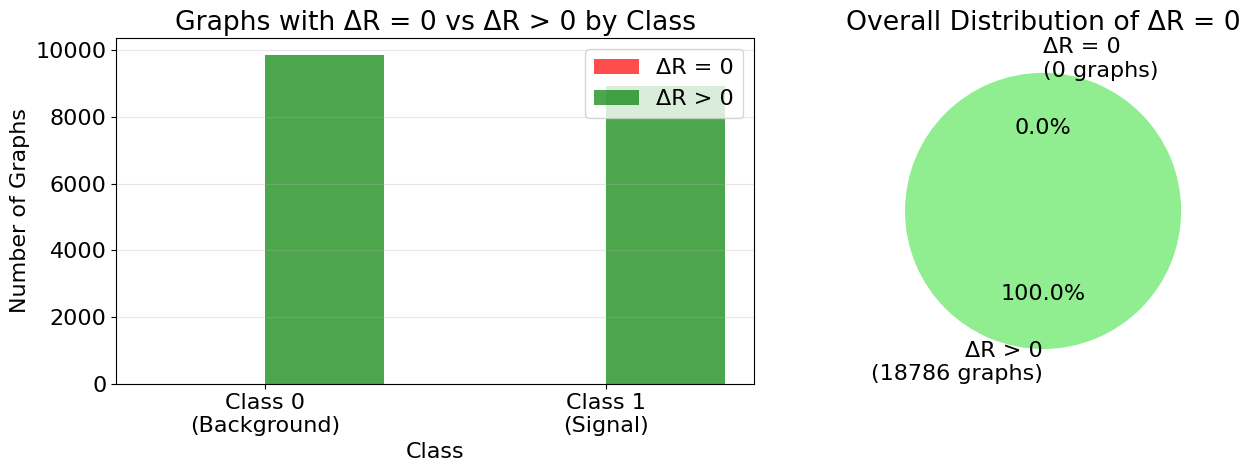

In [15]:
import numpy as np

# Conta i grafi con ΔR = 0 per ciascuna classe
width_class0_array = np.array(width_class0)
width_class1_array = np.array(width_class1)

zero_width_class0 = np.sum(width_class0_array == 0.0)
zero_width_class1 = np.sum(width_class1_array == 0.0)

total_class0 = len(width_class0)
total_class1 = len(width_class1)

print(f"\n{'='*60}")
print(f"Analisi grafi con ΔR = 0")
print(f"{'='*60}")
print(f"\nClass 0 (Background):")
print(f"  Grafi con ΔR = 0: {zero_width_class0}/{total_class0} ({100*zero_width_class0/total_class0:.2f}%)")
print(f"  Grafi con ΔR > 0: {total_class0 - zero_width_class0}/{total_class0} ({100*(total_class0-zero_width_class0)/total_class0:.2f}%)")

print(f"\nClass 1 (Signal):")
print(f"  Grafi con ΔR = 0: {zero_width_class1}/{total_class1} ({100*zero_width_class1/total_class1:.2f}%)")
print(f"  Grafi con ΔR > 0: {total_class1 - zero_width_class1}/{total_class1} ({100*(total_class1-zero_width_class1)/total_class1:.2f}%)")

print(f"\nTotale:")
print(f"  Grafi con ΔR = 0: {zero_width_class0 + zero_width_class1}/{total_class0 + total_class1} ({100*(zero_width_class0+zero_width_class1)/(total_class0+total_class1):.2f}%)")
print(f"{'='*60}\n")

# Visualizzazione
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Grafico a barre per classe
classes = ['Class 0\n(Background)', 'Class 1\n(Signal)']
zero_counts = [zero_width_class0, zero_width_class1]
nonzero_counts = [total_class0 - zero_width_class0, total_class1 - zero_width_class1]

x = np.arange(len(classes))
width_bar = 0.35

ax1.bar(x - width_bar/2, zero_counts, width_bar, label='ΔR = 0', color='red', alpha=0.7)
ax1.bar(x + width_bar/2, nonzero_counts, width_bar, label='ΔR > 0', color='green', alpha=0.7)
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of Graphs')
ax1.set_title('Graphs with ΔR = 0 vs ΔR > 0 by Class')
ax1.set_xticks(x)
ax1.set_xticklabels(classes)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Grafico a torta per totale
labels = [f'ΔR = 0\n({zero_width_class0 + zero_width_class1} graphs)', 
          f'ΔR > 0\n({total_class0 + total_class1 - zero_width_class0 - zero_width_class1} graphs)']
sizes = [zero_width_class0 + zero_width_class1, 
         total_class0 + total_class1 - zero_width_class0 - zero_width_class1]
colors = ['#ff9999', '#90ee90']

ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Overall Distribution of ΔR = 0')

plt.tight_layout()
plt.savefig("deltaR_zero_analysis.pdf")
plt.show()

In [16]:
# Verifica il problema con gli indici
print(f"\n{'='*60}")
print(f"DEBUG: Verifica indici grafi con ΔR = 0")
print(f"{'='*60}\n")

# Gli indici in zero_width_indices sono relativi a (width_class0 + width_class1)
# NON sono indici diretti del testset!

# Esempio: se width_class0 ha 1000 elementi e width_class1 ha 1000 elementi
# allora zero_width_indices[500] si riferisce a width_class0[500]
# ma zero_width_indices[1200] si riferisce a width_class1[200]

# Dobbiamo ricostruire correttamente gli indici
zero_width_class0_indices = []
zero_width_class1_indices = []

for i, w in enumerate(width_class0):
    if w == 0.0:
        # Trova l'indice reale nel testset per class 0
        count = 0
        for idx, data in enumerate(testset):
            if data.y.item() == 0:
                if count == i:
                    zero_width_class0_indices.append(idx)
                    break
                count += 1

for i, w in enumerate(width_class1):
    if w == 0.0:
        # Trova l'indice reale nel testset per class 1
        count = 0
        for idx, data in enumerate(testset):
            if data.y.item() == 1:
                if count == i:
                    zero_width_class1_indices.append(idx)
                    break
                count += 1

print(f"Grafi class 0 con ΔR = 0: {len(zero_width_class0_indices)}")
print(f"Grafi class 1 con ΔR = 0: {len(zero_width_class1_indices)}")

# Ora analizza correttamente
single_layer = 0
multi_layer_single_nodes = 0
same_coords = 0

all_zero_indices = zero_width_class0_indices + zero_width_class1_indices

for idx in all_zero_indices[:5]:  # Primi 5 esempi
    data = testset[idx]
    x = data.x
    layers = x[:, 0]
    unique_layers = torch.unique(layers)
    
    print(f"\nGrafo #{idx} (Label: {data.y.item()}):")
    print(f"  Nodi totali: {x.size(0)}")
    print(f"  Layers: {unique_layers.tolist()}")
    
    if len(unique_layers) == 1:
        print(f"  → Pattern: SINGLE LAYER")
        single_layer += 1
    else:
        max_nodes = max([(layers == l).sum().item() for l in unique_layers])
        print(f"  → Max nodi per layer: {max_nodes}")
        if max_nodes < 2:
            print(f"  → Pattern: MULTI-LAYER CON TUTTI LAYER < 2 NODI")
            multi_layer_single_nodes += 1
        else:
            print(f"  → Pattern: POSSIBILE BUG O COORDINATE IDENTICHE")
            same_coords += 1

print(f"\n{'='*60}\n")


DEBUG: Verifica indici grafi con ΔR = 0

Grafi class 0 con ΔR = 0: 0
Grafi class 1 con ΔR = 0: 0




In [17]:
import torch

# Initialize layer counters
total_layer_counts = torch.zeros(4, dtype=torch.long)

for data in testset:
    layer = data.x[:, 0]  # Layer index is in column 0
    for l in range(4):
        total_layer_counts[l] += (layer == l).sum()

# Print results
for l in range(4):
    print(f"Total nodes in Layer {l}: {total_layer_counts[l].item()}")

    layer_counts = [(layer == l).sum().item() for l in range(4)]

Total nodes in Layer 0: 112801
Total nodes in Layer 1: 32836
Total nodes in Layer 2: 29047
Total nodes in Layer 3: 8951


## Statistics after training

In [18]:
# ---- CONFIGURATION ----
input_size = 4
hidden_size = 40
encoding_size = 2
g_norm = False
heads = 2
num_xprtz = 6
xprt_size = 35
k = 2
dropout_encoder = 0.2
layers = 2
output_size = 2
w_load = 3
batchsize = 256
seed = 3958239256
noise_scale = 2.0  
model_ckpt_path = '/hdd3/dongen/Desktop/darkphoton/train/results/MoE_multi_seed_datamodified/checkpoint_run_1.pth'

In [19]:
# ---- MODEL ----
model = Transformer(
    input_size, hidden_size, encoding_size, g_norm, heads,
    num_xprtz, xprt_size, k, dropout_encoder, layers, output_size
).to(device)

checkpoint = torch.load(model_ckpt_path, map_location=device)
model.load_state_dict(checkpoint['model'])
model.eval()

criterion = torch.nn.CrossEntropyLoss()
loss = LoadBalancingLoss(criterion, 0)

In [22]:
set_seed_everything(seed)
# ---- EVALUATION ----
result = evaluate(test_loader, model, loss, device)
predictions = torch.argmax(torch.cat(result[0]), dim=1)
truths = torch.cat(result[1])
which_node = torch.cat(result[4], dim=-1).cpu()

# Save evaluation metrics
acc = accuracy_score(truths.cpu(), predictions.cpu())
precision = precision_score(truths.cpu(), predictions.cpu())
recall = recall_score(truths.cpu(), predictions.cpu())
test_auroc_sklearn = roc_auc_score(truths.cpu(), torch.cat(result[0])[:, 1].cpu())
confmat = confusion_matrix(truths.cpu(), predictions.cpu())
print(f"Accuracy: {acc:.4f}, AUROC: {test_auroc_sklearn:.4f}")


Accuracy: 0.8726, AUROC: 0.9485


In [33]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prepare containers for each group
eratio_TP, width_TP = [], []
eratio_TN, width_TN = [], []
eratio_FP, width_FP = [], []
eratio_FN, width_FN = [], []

# Create index lists for each group
TP_idx = ((predictions == 1) & (truths == 1)).nonzero(as_tuple=True)[0]
TN_idx = ((predictions == 0) & (truths == 0)).nonzero(as_tuple=True)[0]
FP_idx = ((predictions == 1) & (truths == 0)).nonzero(as_tuple=True)[0]
FN_idx = ((predictions == 0) & (truths == 1)).nonzero(as_tuple=True)[0]

In [34]:
# Helper to collect eratio/width for given indices
def collect_metrics(indices, eratio_list, width_list):
    for i in indices:
        data = testset[i]
        x = data.x
        eratio, width = compute_graph_quantities(x)
        eratio_list.append(eratio)
        width_list.append(width)

In [35]:
# Collect metrics
collect_metrics(TP_idx, eratio_TP, width_TP)
collect_metrics(TN_idx, eratio_TN, width_TN)
collect_metrics(FP_idx, eratio_FP, width_FP)
collect_metrics(FN_idx, eratio_FN, width_FN)

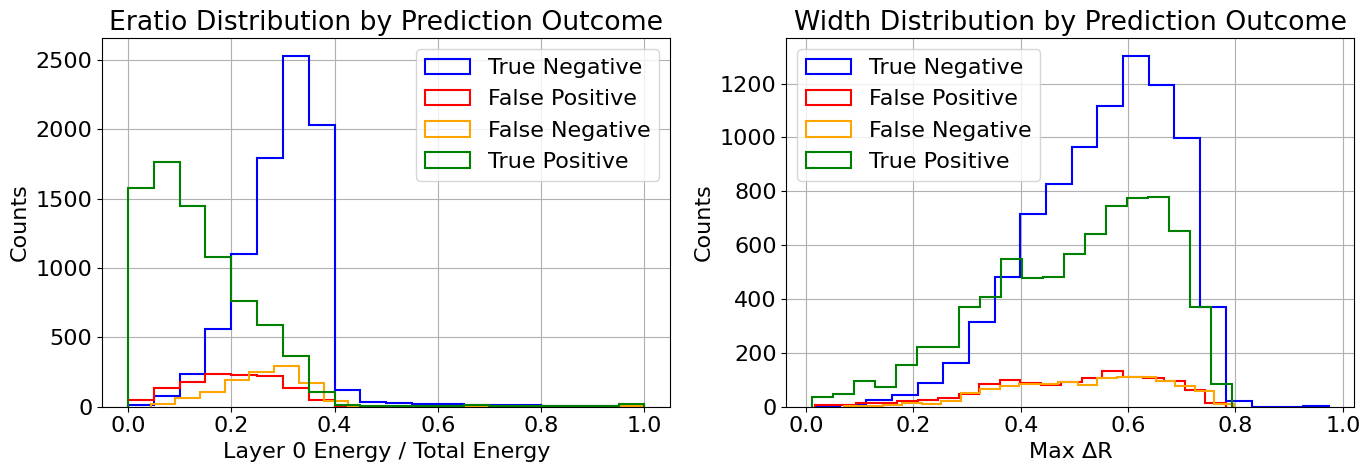

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Eratio plot with borders only
plt.subplot(1, 2, 1)
plt.hist(eratio_TN, bins=20, color='blue', label='True Negative', histtype='step', linewidth=1.5)
plt.hist(eratio_FP, bins=20, color='red', label='False Positive', histtype='step', linewidth=1.5)
plt.hist(eratio_FN, bins=20, color='orange', label='False Negative', histtype='step', linewidth=1.5)
plt.hist(eratio_TP, bins=20, color='green', label='True Positive', histtype='step', linewidth=1.5)
plt.title('Eratio Distribution by Prediction Outcome')
plt.xlabel('Layer 0 Energy / Total Energy')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)

# Width plot with borders only
plt.subplot(1, 2, 2)
plt.hist(width_TN, bins=20, color='blue', label='True Negative', histtype='step', linewidth=1.5)
plt.hist(width_FP, bins=20, color='red', label='False Positive', histtype='step', linewidth=1.5)
plt.hist(width_FN, bins=20, color='orange', label='False Negative', histtype='step', linewidth=1.5)
plt.hist(width_TP, bins=20, color='green', label='True Positive', histtype='step', linewidth=1.5)
plt.title('Width Distribution by Prediction Outcome')
plt.xlabel('Max ΔR')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



<Figure size 1600x1200 with 0 Axes>

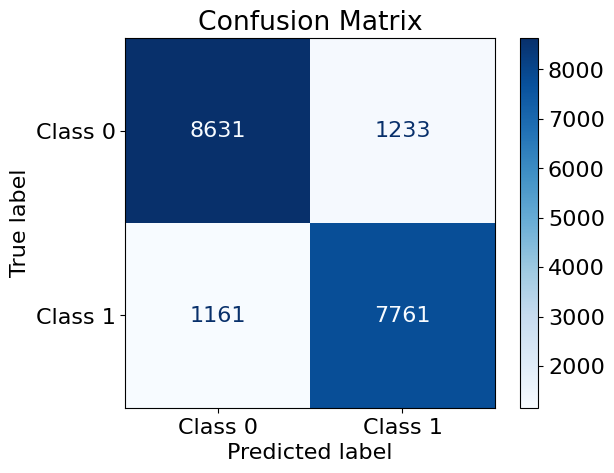

In [37]:
# Plot confusion matrix
plt.figure(figsize=(16, 12))

cm = confusion_matrix(truths.cpu(), predictions.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

<Figure size 1600x1200 with 0 Axes>

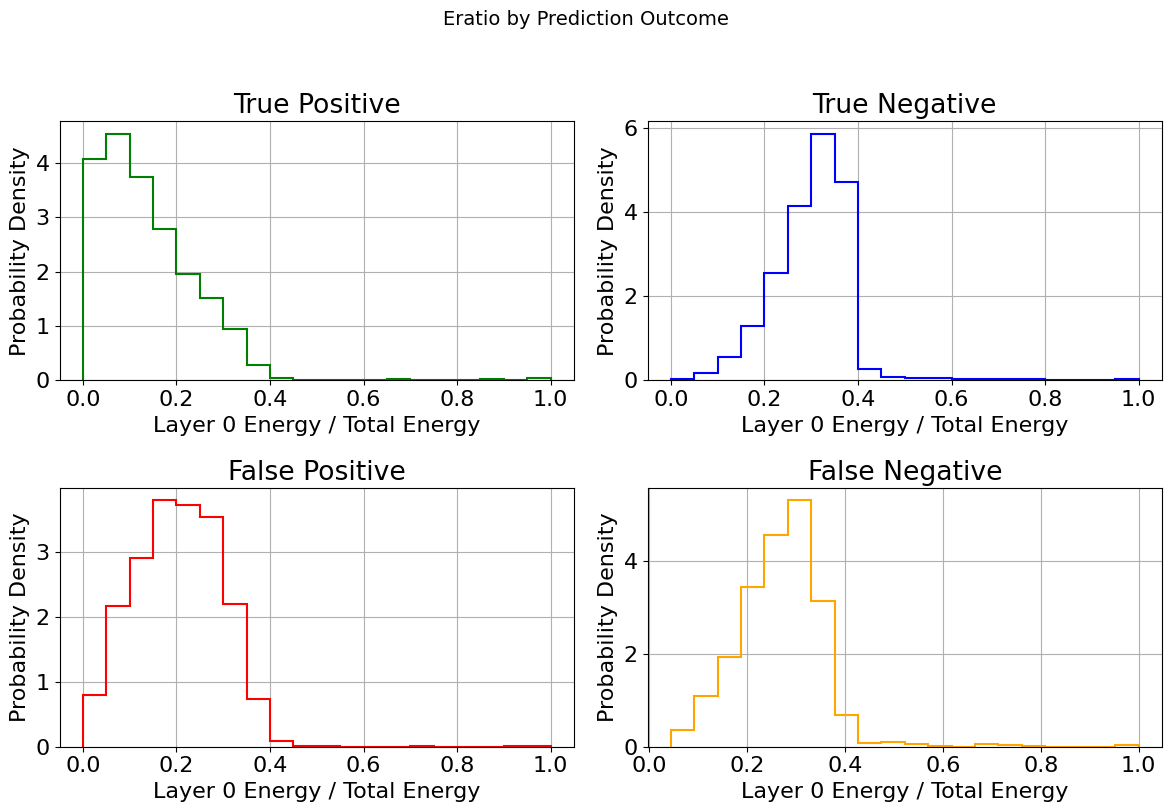

In [38]:
import matplotlib.pyplot as plt

# Data, label, color for each category
plt.rc('font', size=16)

plt.figure(figsize=(16, 12))

plot_info = [
    (eratio_TP, 'True Positive', 'green'),
    (eratio_TN, 'True Negative', 'blue'),
    (eratio_FP, 'False Positive', 'red'),
    (eratio_FN, 'False Negative', 'orange')
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, (data, label, color) in zip(axes.flatten(), plot_info):
    ax.hist(
        data,
        bins=20,
        color=color,
        histtype='step',
        linewidth=1.5,
        density=True  # normalize for shape comparison
    )
    ax.set_title(f'{label}')
    ax.set_xlabel('Layer 0 Energy / Total Energy')
    ax.set_ylabel('Probability Density')
    ax.grid(True)

plt.suptitle('Eratio by Prediction Outcome', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("eratio_prediction_outcome.pdf")
plt.show()

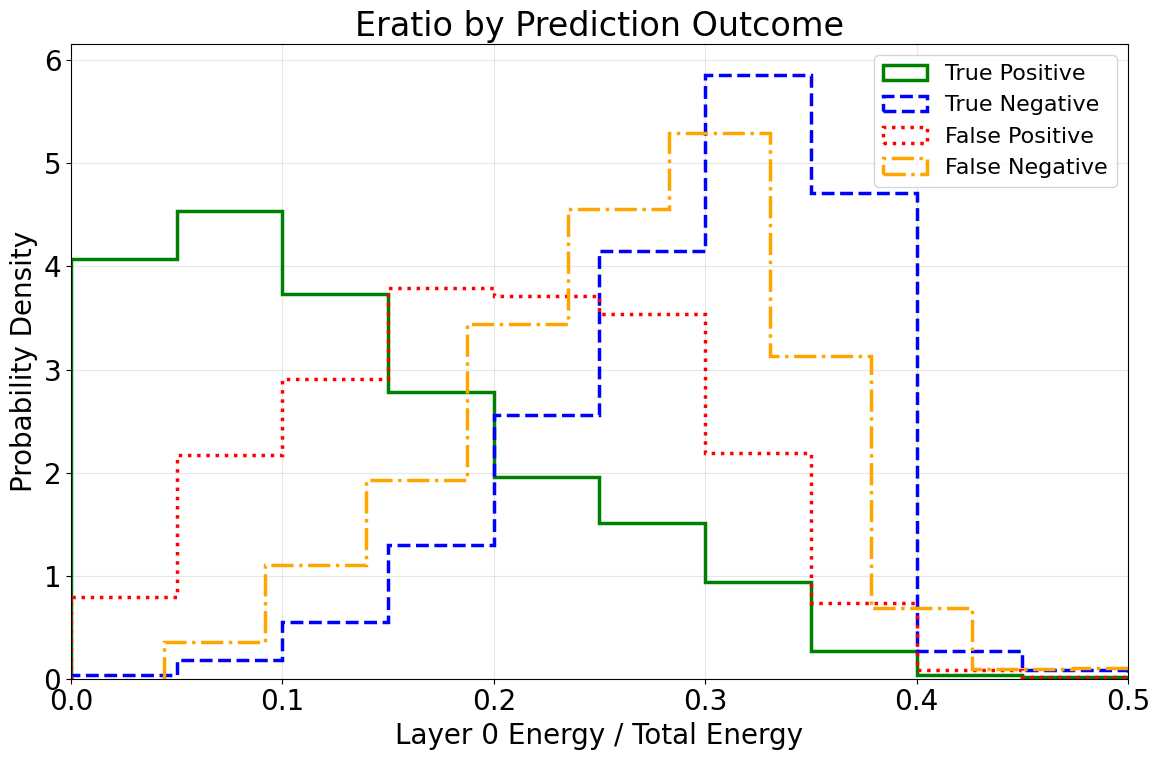

In [39]:
import matplotlib.pyplot as plt

# Font generale più grande
plt.rc('font', size=20)  # aumentato da 16 a 20

plt.figure(figsize=(12, 8))

# Informazioni: dati, etichetta, colore, stile linea
plot_info = [
    (eratio_TP, 'True Positive', 'green', '-'),   
    (eratio_TN, 'True Negative', 'blue', '--'),   
    (eratio_FP, 'False Positive', 'red', ':'),    
    (eratio_FN, 'False Negative', 'orange', '-.') 
]

# Istogrammi tutti insieme
for data, label, color, style in plot_info:
    plt.hist(
        data,
        bins=20,
        histtype='step',
        linewidth=2.5,
        density=True,
        label=label,
        color=color,
        linestyle=style
    )

plt.title("Eratio by Prediction Outcome", fontsize=24)
plt.xlabel("Layer 0 Energy / Total Energy", fontsize=20)
plt.ylabel("Probability Density", fontsize=20)

plt.xlim(0, 0.5)  # <-- Forza range x da 0 a 0.5
plt.grid(True, alpha=0.3)
plt.legend(fontsize=16)

plt.tight_layout()
plt.savefig("eratio_all_together.pdf")
plt.show()



<Figure size 1600x1200 with 0 Axes>

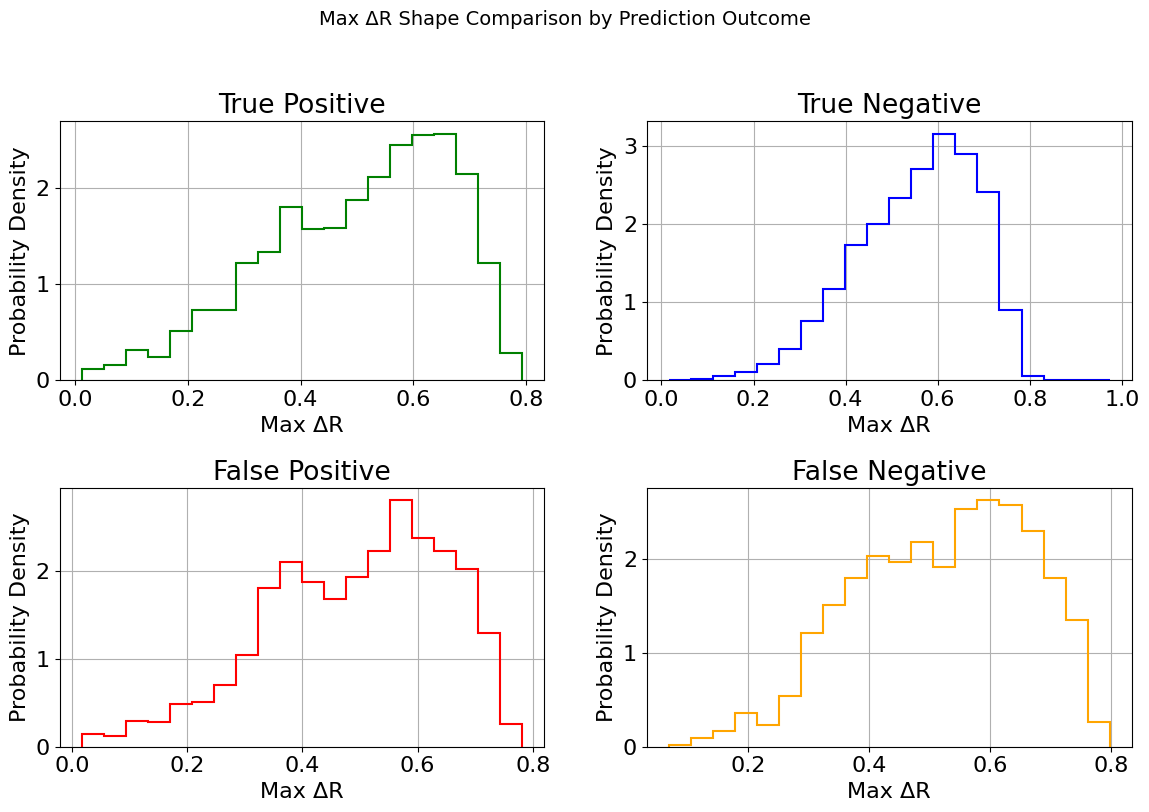

In [40]:
import matplotlib.pyplot as plt

# Data, label, color for each category
plt.rc('font', size=16)

plt.figure(figsize=(16, 12))

plot_info = [
    (width_TP, 'True Positive', 'green'),
    (width_TN, 'True Negative', 'blue'),
    (width_FP, 'False Positive', 'red'),
    (width_FN, 'False Negative', 'orange')
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, (data, label, color) in zip(axes.flatten(), plot_info):
    ax.hist(
        data,
        bins=20,
        color=color,
        histtype='step',
        linewidth=1.5,
        density=True  # normalize for shape comparison
    )
    ax.set_title(f'{label}')
    ax.set_xlabel('Max ΔR')
    ax.set_ylabel('Probability Density')
    ax.grid(True)

plt.suptitle('Max ΔR Shape Comparison by Prediction Outcome', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("deltaR.pdf")
plt.show()


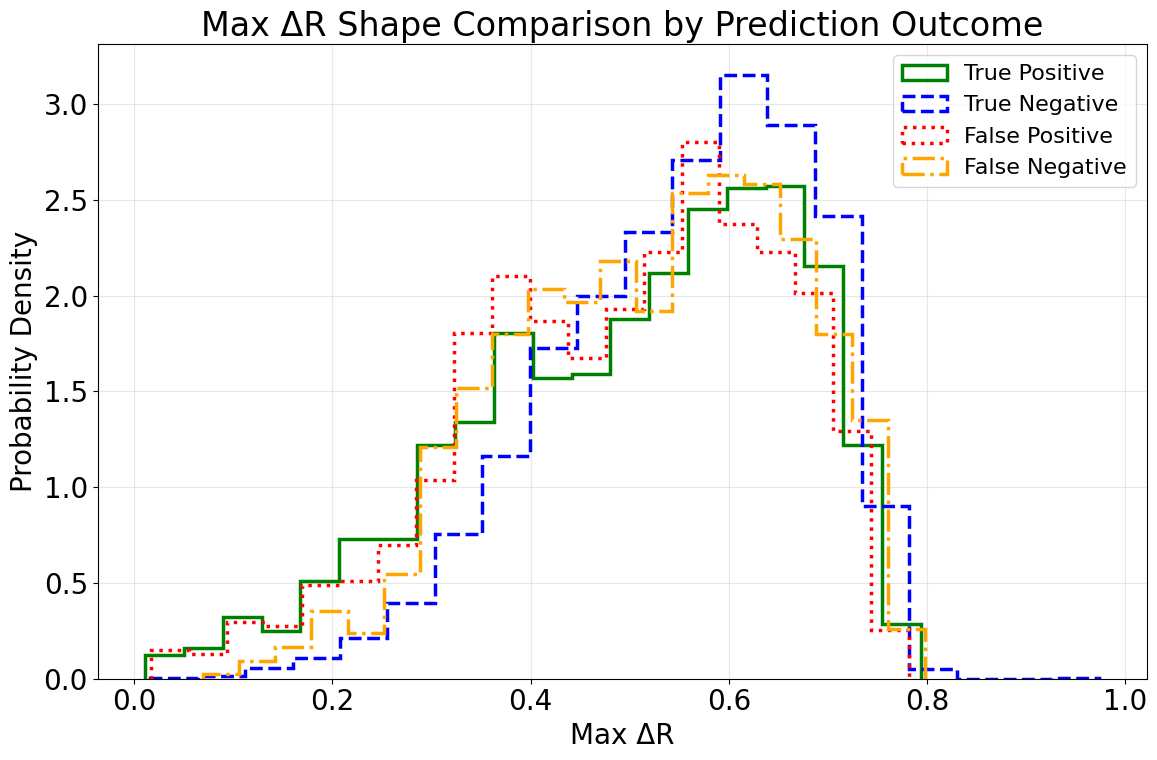

In [42]:
import matplotlib.pyplot as plt

# Font generale più grande
plt.rc('font', size=20)  # aumentato da 16 a 20

plt.figure(figsize=(12, 8))

# Aggiunto il 4° elemento alla tupla: lo stile della linea
plot_info = [
    (width_TP, 'True Positive', 'green', '-'),    # Linea continua
    (width_TN, 'True Negative', 'blue', '--'),    # Tratteggiata
    (width_FP, 'False Positive', 'red', ':'),     # Punteggiata
    (width_FN, 'False Negative', 'orange', '-.')  # Tratto-punto
]

# Istogrammi tutti insieme
for data, label, color, style in plot_info:
    plt.hist(
        data,
        bins=20,
        histtype='step',
        linewidth=2.5,     
        density=True,
        label=label,
        color=color,
        linestyle=style    
    )

plt.title("Max ΔR Shape Comparison by Prediction Outcome", fontsize=24)
plt.xlabel("Max ΔR", fontsize=20)
plt.ylabel("Probability Density", fontsize=20)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=16)

plt.tight_layout()
plt.savefig("deltaR_all_together.pdf")
plt.show()


In [43]:
!pip install fastjet

In [44]:
import fastjet as fj


In [45]:
def compute_pt_from_hits(x):
    """
    Compute reconstructed pT using FastJet clustering
    x: tensor of shape [num_nodes, 4] with [layer, eta, phi, energy]
    """
    clusters = []
    
    # Convert detector hits to pseudojets
    for idx in range(x.shape[0]):
        eta = x[idx, 1].item()+idx*0.001
        phi = x[idx, 2].item()+idx*0.001
        energy = x[idx, 3].item()*15
        
        clusters.append(fj.PseudoJet(energy, eta, phi, 0.0))
        
    # Define the clustering algorithm with the anti-kt algorithm and radius parameter
    jet_def = fj.JetDefinition(fj.cambridge_algorithm, 100)
    # Create a ClusterSequence with the particles and jet definition
    sequence = fj.ClusterSequence(clusters, jet_def)
    # Get inclusive jets
    jets = sequence.inclusive_jets()

    # Print the clustered jets
    #for i, jet in enumerate(jets):
        #print(f"Jet {i + 1}: pt = {jet.pt()}, eta = {jet.eta()}, phi = {jet.phi()}, mass = {jet.m()}")
    return jets[0].pt()

In [46]:
# Update the compute_graph_quantities function to include pT
def compute_graph_quantities(x):
    eta = x[:, 1]
    phi = x[:, 2]
    energy = x[:, 3]
    layer = x[:, 0]

    # 1. pT calculation
    pt = compute_pt_from_hits(x)

    # 2. Eratio
    layer0_energy = energy[layer == 0].sum()
    total_energy = energy.sum()
    eratio = (layer0_energy / total_energy).item() if total_energy > 0 else 0.0

    # 3. Width
    widths = []
    for l in range(4):
        mask = (layer == l)
        coords = x[mask][:, 1:3]  # [eta, phi]
        if coords.size(0) < 2:
            continue
        diff = coords.unsqueeze(0) - coords.unsqueeze(1)
        dR = torch.norm(diff, dim=-1)
        max_dR = dR.max().item()
        widths.append(max_dR)
    width = max(widths) if widths else 0.0

    return eratio, width, pt

In [47]:
# Prepare containers for each group (now including pT)
eratio_TP, width_TP, pt_TP = [], [], []
eratio_TN, width_TN, pt_TN = [], [], []
eratio_FP, width_FP, pt_FP = [], [], []
eratio_FN, width_FN, pt_FN = [], [], []

# Helper to collect eratio/width/pT for given indices
def collect_metrics_with_pt(indices, eratio_list, width_list, pt_list):
    for i in indices:
        data = testset[i]
        x = data.x
        eratio, width, pt = compute_graph_quantities(x)
        eratio_list.append(eratio)
        width_list.append(width)
        pt_list.append(pt)

# Collect metrics for all groups
collect_metrics_with_pt(TP_idx, eratio_TP, width_TP, pt_TP)
collect_metrics_with_pt(TN_idx, eratio_TN, width_TN, pt_TN)
collect_metrics_with_pt(FP_idx, eratio_FP, width_FP, pt_FP)
collect_metrics_with_pt(FN_idx, eratio_FN, width_FN, pt_FN)

#--------------------------------------------------------------------------
#                         FastJet release 3.5.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


<Figure size 1600x1200 with 0 Axes>

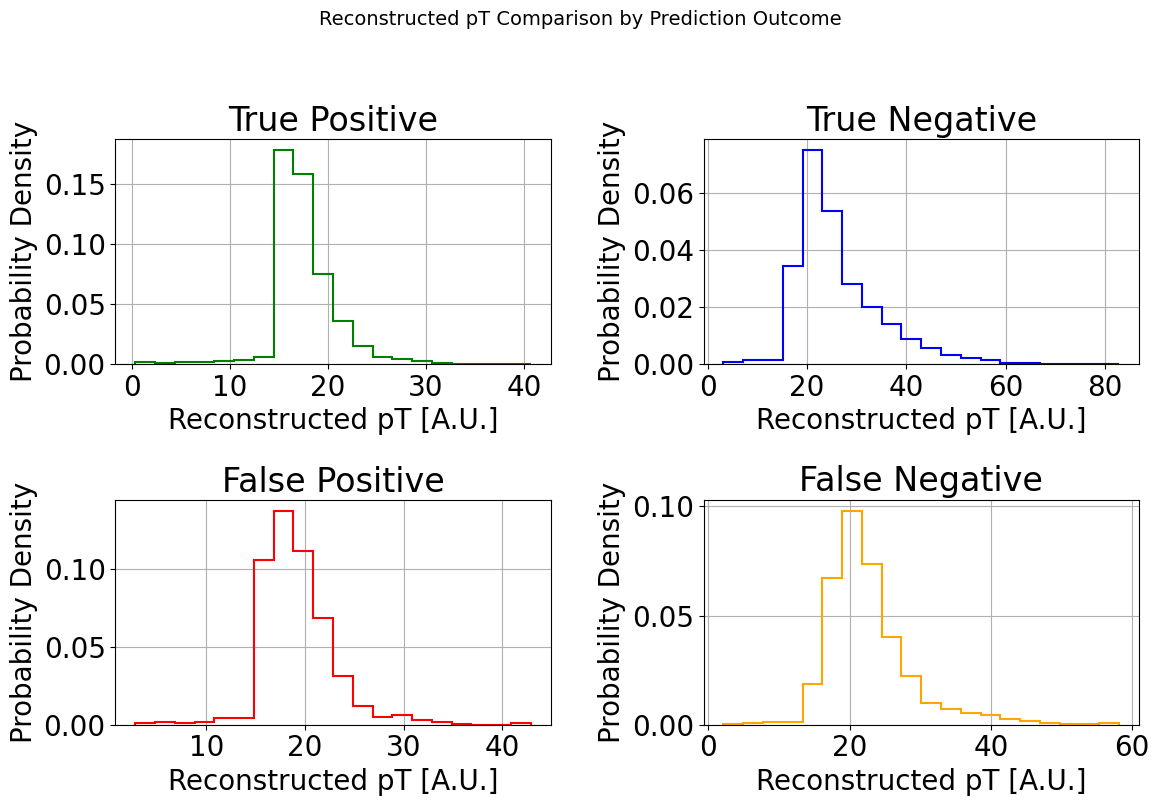

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12))

# Data, label, color for each category
plot_info = [
    (pt_TP, 'True Positive', 'green'),
    (pt_TN, 'True Negative', 'blue'),
    (pt_FP, 'False Positive', 'red'),
    (pt_FN, 'False Negative', 'orange')
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, (data, label, color) in zip(axes.flatten(), plot_info):
    ax.hist(
        data,
        bins=20,
        color=color,
        histtype='step',
        linewidth=1.5,
        density=True  # normalize for shape comparison
    )
    ax.set_title(f'{label}')
    ax.set_xlabel('Reconstructed pT [A.U.]')
    ax.set_ylabel('Probability Density')
    ax.grid(True)

plt.suptitle('Reconstructed pT Comparison by Prediction Outcome', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("pT.pdf")
plt.show()

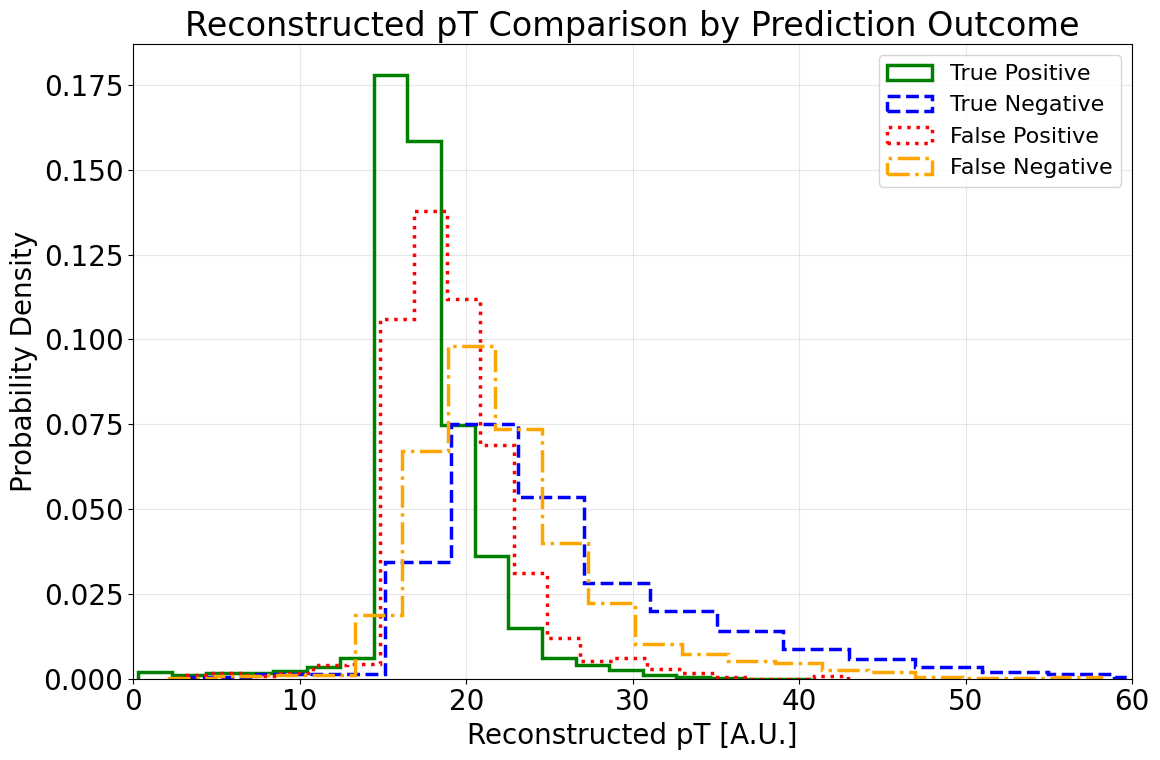

In [49]:
import matplotlib.pyplot as plt

# Font generale più grande
plt.rc('font', size=20)  # aumentato da 16 a 20

plt.figure(figsize=(12, 8))

# Data, label, color, stile linea
plot_info = [
    (pt_TP, 'True Positive', 'green', '-'),    # Linea continua
    (pt_TN, 'True Negative', 'blue', '--'),    # Tratteggiata
    (pt_FP, 'False Positive', 'red', ':'),     # Punteggiata
    (pt_FN, 'False Negative', 'orange', '-.')  # Tratto-punto
]

# Istogrammi tutti insieme
for data, label, color, style in plot_info:
    plt.hist(
        data,
        bins=20,
        histtype='step',
        linewidth=2.5,      
        density=True,
        label=label,
        color=color,
        linestyle=style     
    )

plt.title("Reconstructed pT Comparison by Prediction Outcome", fontsize=24)
plt.xlabel("Reconstructed pT [A.U.]", fontsize=20)
plt.ylabel("Probability Density", fontsize=20)

plt.xlim(0, 60)  # Limite asse x da 0 a 0.60
plt.grid(True, alpha=0.3)
plt.legend(fontsize=16)

plt.tight_layout()
plt.savefig("pT_all_together.pdf")
plt.show()


<Figure size 1600x1200 with 0 Axes>

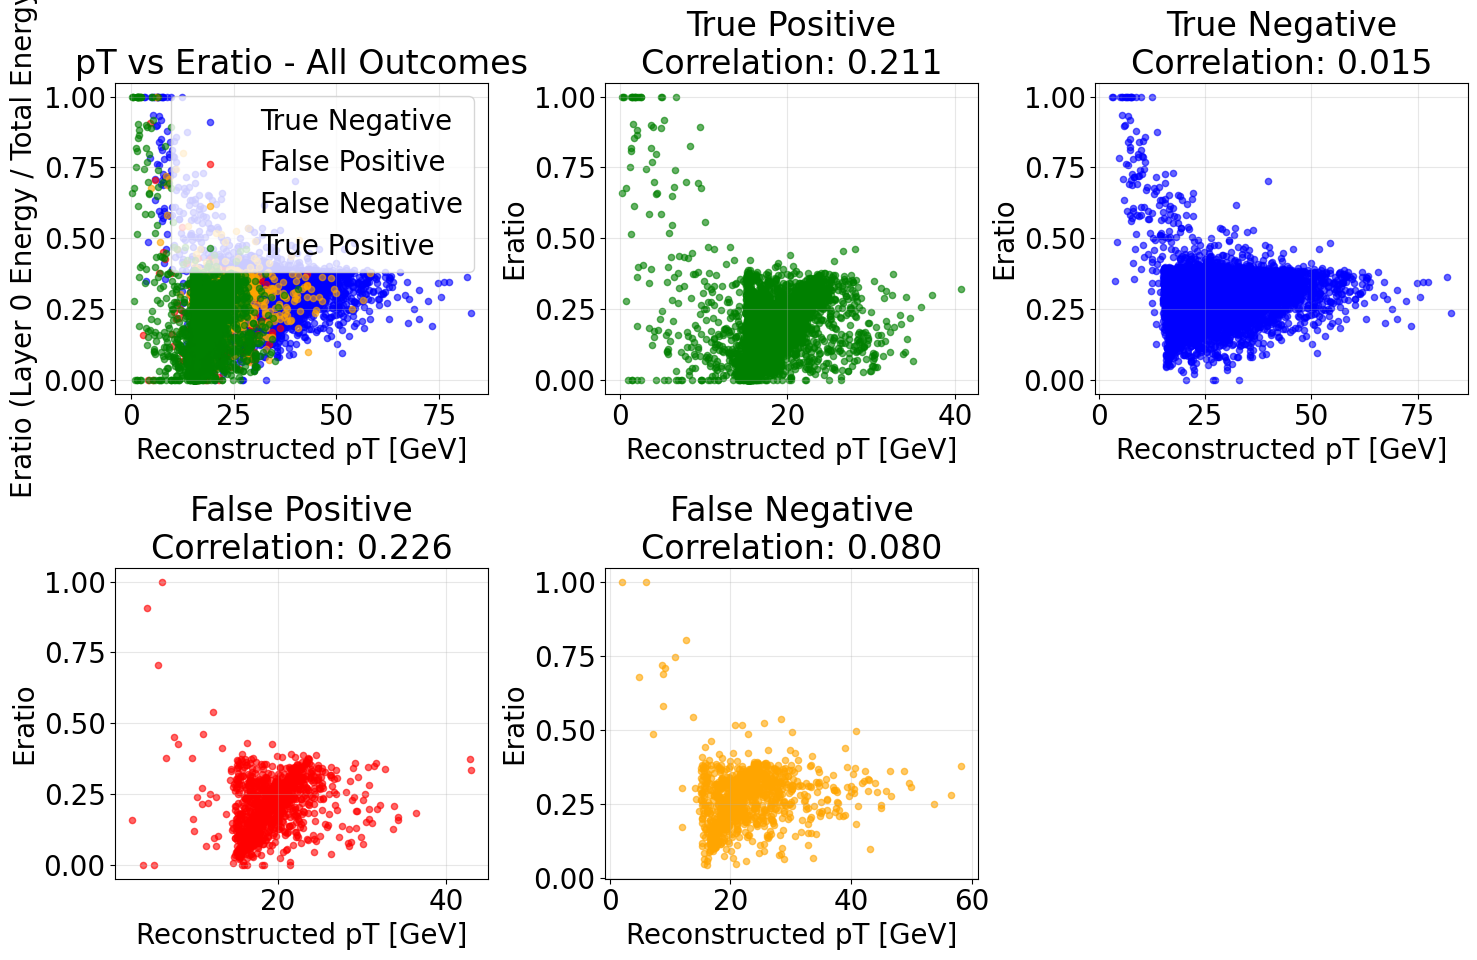

Correlation Coefficients (pT vs Eratio):
True Positive: 0.2108
True Negative: 0.0148
False Positive: 0.2261
False Negative: 0.0802


In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Create correlation plots for pT vs eratio
plt.figure(figsize=(16, 12))
plt.figure(figsize=(15, 10))

# Plot 1: All prediction outcomes overlaid
plt.subplot(2, 3, 1)
plt.scatter(pt_TN, eratio_TN, alpha=0.6, color='blue', label='True Negative', s=20)
plt.scatter(pt_FP, eratio_FP, alpha=0.6, color='red', label='False Positive', s=20)
plt.scatter(pt_FN, eratio_FN, alpha=0.6, color='orange', label='False Negative', s=20)
plt.scatter(pt_TP, eratio_TP, alpha=0.6, color='green', label='True Positive', s=20)
plt.xlabel('Reconstructed pT [GeV]')
plt.ylabel('Eratio (Layer 0 Energy / Total Energy)')
plt.title('pT vs Eratio - All Outcomes')
plt.legend()
plt.grid(True, alpha=0.3)

# Individual plots for each outcome
outcomes = [
    (pt_TP, eratio_TP, 'True Positive', 'green'),
    (pt_TN, eratio_TN, 'True Negative', 'blue'),
    (pt_FP, eratio_FP, 'False Positive', 'red'),
    (pt_FN, eratio_FN, 'False Negative', 'orange')
]

for i, (pt_data, eratio_data, label, color) in enumerate(outcomes, 2):
    plt.subplot(2, 3, i)
    plt.scatter(pt_data, eratio_data, alpha=0.6, color=color, s=20)
    
    # Calculate and display correlation coefficient
    if len(pt_data) > 1:
        correlation = np.corrcoef(pt_data, eratio_data)[0, 1]
        plt.title(f'{label}\nCorrelation: {correlation:.3f}')
    else:
        plt.title(f'{label}')
    
    plt.xlabel('Reconstructed pT [GeV]')
    plt.ylabel('Eratio')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print correlation coefficients
print("Correlation Coefficients (pT vs Eratio):")
for pt_data, eratio_data, label, _ in outcomes:
    if len(pt_data) > 1:
        correlation = np.corrcoef(pt_data, eratio_data)[0, 1]
        print(f"{label}: {correlation:.4f}")
    else:
        print(f"{label}: Not enough data points")

In [51]:
outcomes_hist = [
    (pt_TP, eratio_TP, 'True Positive', 'Greens'),
    (pt_TN, eratio_TN, 'True Negative', 'Blues'),
    (pt_FP, eratio_FP, 'False Positive', 'Reds'),
    (pt_FN, eratio_FN, 'False Negative', 'Oranges')
]

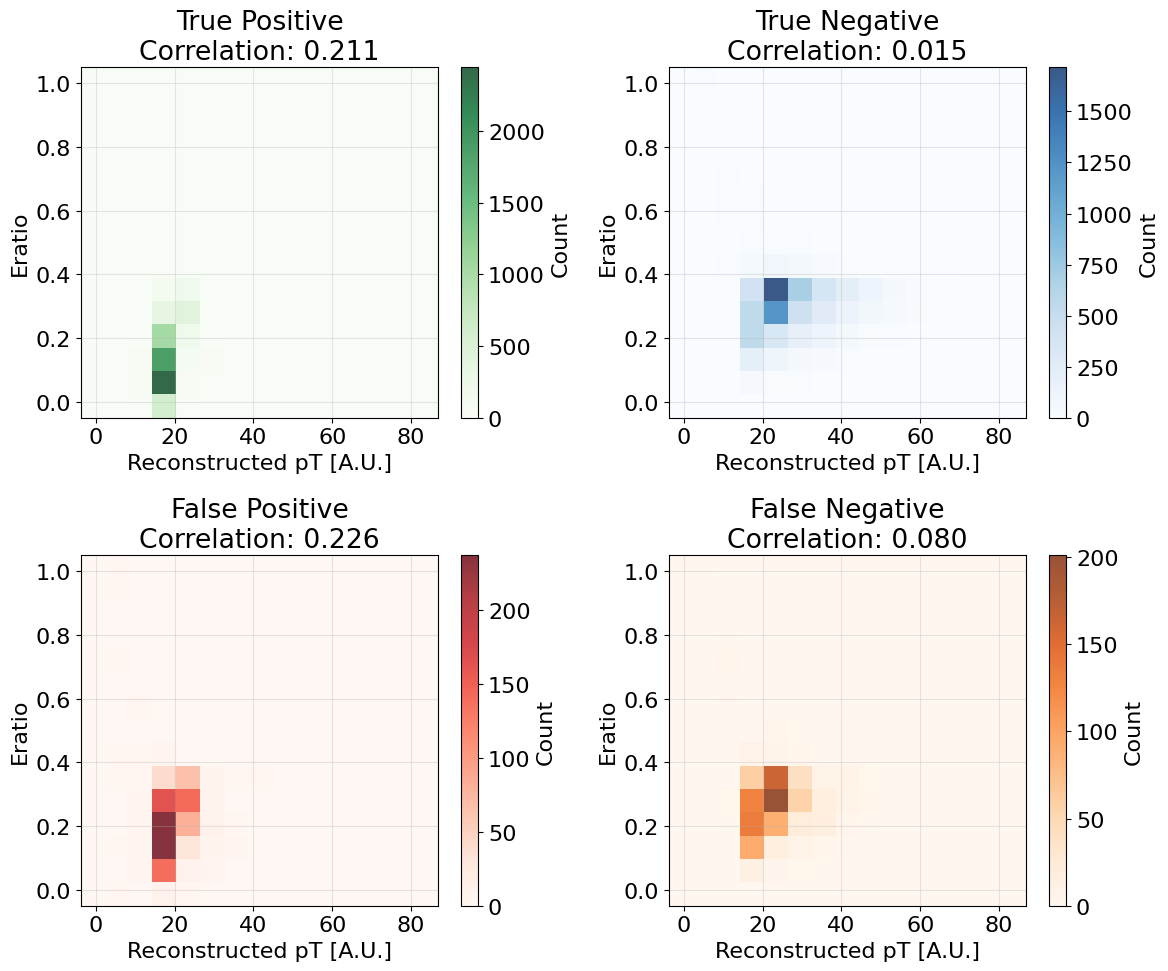

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# --- Determine global axis limits ---
all_pt = np.concatenate([arr for arr, _, _, _ in outcomes_hist if len(arr) > 0])
all_eratio = np.concatenate([arr for _, arr, _, _ in outcomes_hist if len(arr) > 0])

x_min, x_max = all_pt.min(), all_pt.max()
y_min, y_max = all_eratio.min(), all_eratio.max()

# Add padding for aesthetics
x_pad = 0.05 * (x_max - x_min) if x_max > x_min else 1
y_pad = 0.05 * (y_max - y_min) if y_max > y_min else 1
x_min -= x_pad
x_max += x_pad
y_min -= y_pad
y_max += y_pad

# --- Plot ---
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(12, 10))

for i, (pt_data, eratio_data, label, cmap) in enumerate(outcomes_hist, 1):
    plt.subplot(2, 2, i)

    if len(pt_data) > 5:
        # Use the same axis range across all histograms
        plt.hist2d(pt_data, eratio_data, bins=15, cmap=cmap, alpha=0.8,range=[[x_min, x_max], [y_min, y_max]])
        plt.colorbar(label='Count')

        # Correlation
        corr = np.corrcoef(pt_data, eratio_data)[0, 1]
        plt.title(f'{label}\nCorrelation: {corr:.3f}')

    elif len(pt_data) > 0:
        plt.scatter(pt_data, eratio_data, alpha=0.7, s=50)
        if len(pt_data) > 1 and np.std(pt_data) > 0 and np.std(eratio_data) > 0:
            corr = np.corrcoef(pt_data, eratio_data)[0, 1]
            plt.title(f'{label}\nCorrelation: {corr:.3f}')
        else:
            plt.title(label)
    else:
        plt.text(0.5, 0.5, 'No data', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(label)

    plt.xlabel('Reconstructed pT [A.U.]')
    plt.ylabel('Eratio')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("correlation1.pdf")
plt.show()


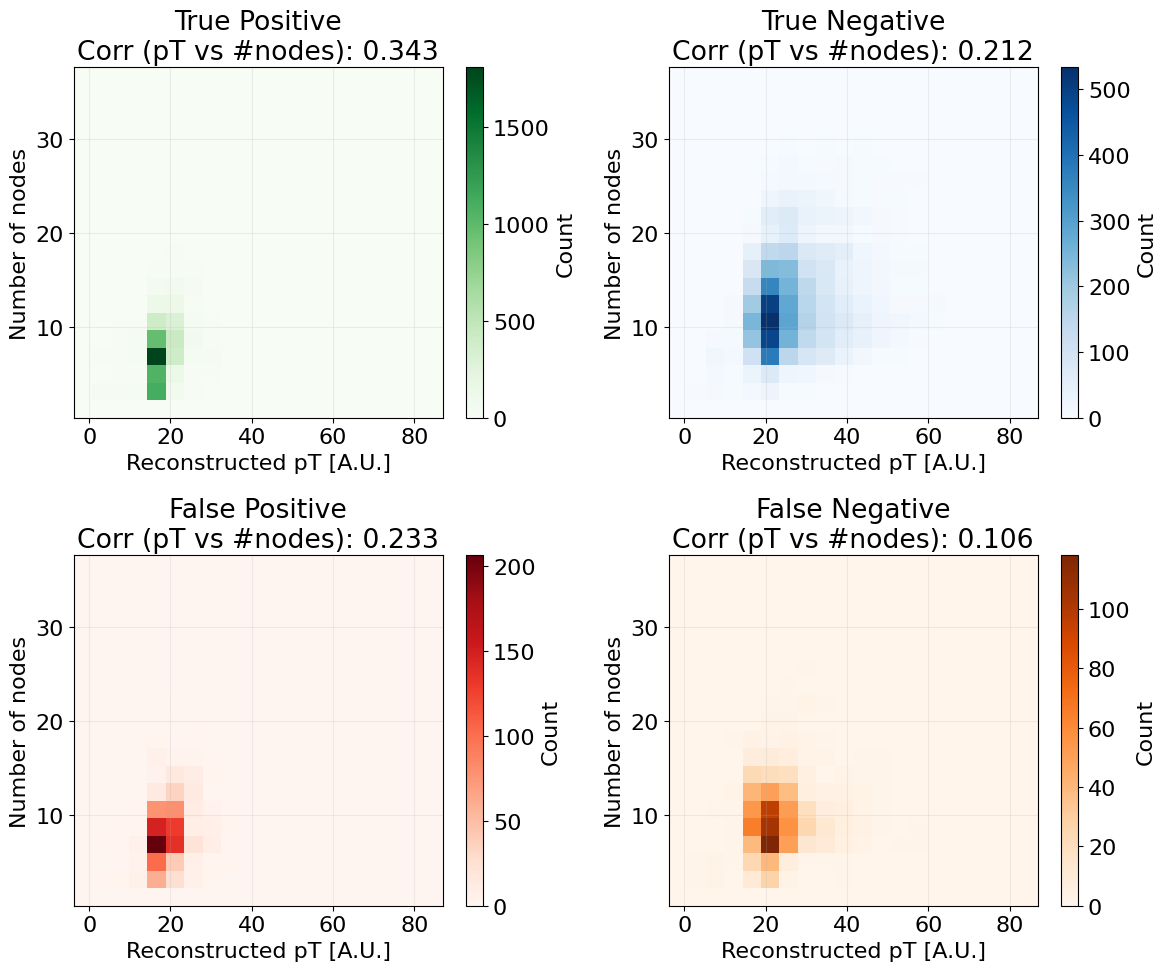

Correlation coefficients (reconstructed pT vs number of nodes):
True Positive: 0.3432
True Negative: 0.2115
False Positive: 0.2325
False Negative: 0.1058


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def collect_nodes_and_pt(indices):
    node_counts = []
    pts = []
    for i in indices:
        data = testset[i]
        node_counts.append(int(data.x.size(0)))
        # get reconstructed pT
        _, _, pt = compute_graph_quantities(data.x)
        try:
            pt_val = float(pt)
        except Exception:
            pt_val = np.asarray(pt).item()
        pts.append(pt_val)
    return np.array(pts), np.array(node_counts)

# compute arrays (pt on x, nodes on y)
pts_TP, nodes_TP = collect_nodes_and_pt(TP_idx)
pts_TN, nodes_TN = collect_nodes_and_pt(TN_idx)
pts_FP, nodes_FP = collect_nodes_and_pt(FP_idx)
pts_FN, nodes_FN = collect_nodes_and_pt(FN_idx)

outcomes = [
    (pts_TP, nodes_TP, 'True Positive', 'Greens'),
    (pts_TN, nodes_TN, 'True Negative', 'Blues'),
    (pts_FP, nodes_FP, 'False Positive', 'Reds'),
    (pts_FN, nodes_FN, 'False Negative', 'Oranges'),
]

# --- Compute global axis limits ---
all_pts = np.concatenate([arr for arr, _, _, _ in outcomes if len(arr) > 0])
all_nodes = np.concatenate([arr for _, arr, _, _ in outcomes if len(arr) > 0])

x_min, x_max = all_pts.min(), all_pts.max()
y_min, y_max = all_nodes.min(), all_nodes.max()

# Add some padding for aesthetics
x_pad = 0.05 * (x_max - x_min) if x_max > x_min else 1
y_pad = 0.05 * (y_max - y_min) if y_max > y_min else 1
x_min -= x_pad
x_max += x_pad
y_min -= y_pad
y_max += y_pad

# --- Plot ---
plt.figure(figsize=(12, 10))
for i, (pts, nodes, label, cmap) in enumerate(outcomes, 1):
    plt.subplot(2, 2, i)
    if len(pts) > 5:
        plt.hist2d(pts, nodes, bins=[20, 20], cmap=cmap, range=[[x_min, x_max], [y_min, y_max]])
        plt.colorbar(label='Count')
    elif len(pts) > 0:
        plt.scatter(pts, nodes, s=30, alpha=0.6)
    else:
        plt.text(0.5, 0.5, 'No data', ha='center', va='center', transform=plt.gca().transAxes)

    # correlation (pt vs nodes)
    if len(pts) > 1 and np.std(pts) > 0 and np.std(nodes) > 0:
        corr = np.corrcoef(pts, nodes)[0, 1]
        plt.title(f'{label}\nCorr (pT vs #nodes): {corr:.3f}')
    else:
        plt.title(label)

    plt.xlabel('Reconstructed pT [A.U.]')
    plt.ylabel('Number of nodes')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig("correlation2.pdf")
plt.show()

# --- Print correlation coefficients ---
print("Correlation coefficients (reconstructed pT vs number of nodes):")
for pts, nodes, label, _ in outcomes:
    if len(pts) > 1 and np.std(pts) > 0 and np.std(nodes) > 0:
        corr = np.corrcoef(pts, nodes)[0, 1]
        print(f"{label}: {corr:.4f}")
    else:
        print(f"{label}: Not enough variance or points to compute correlation")


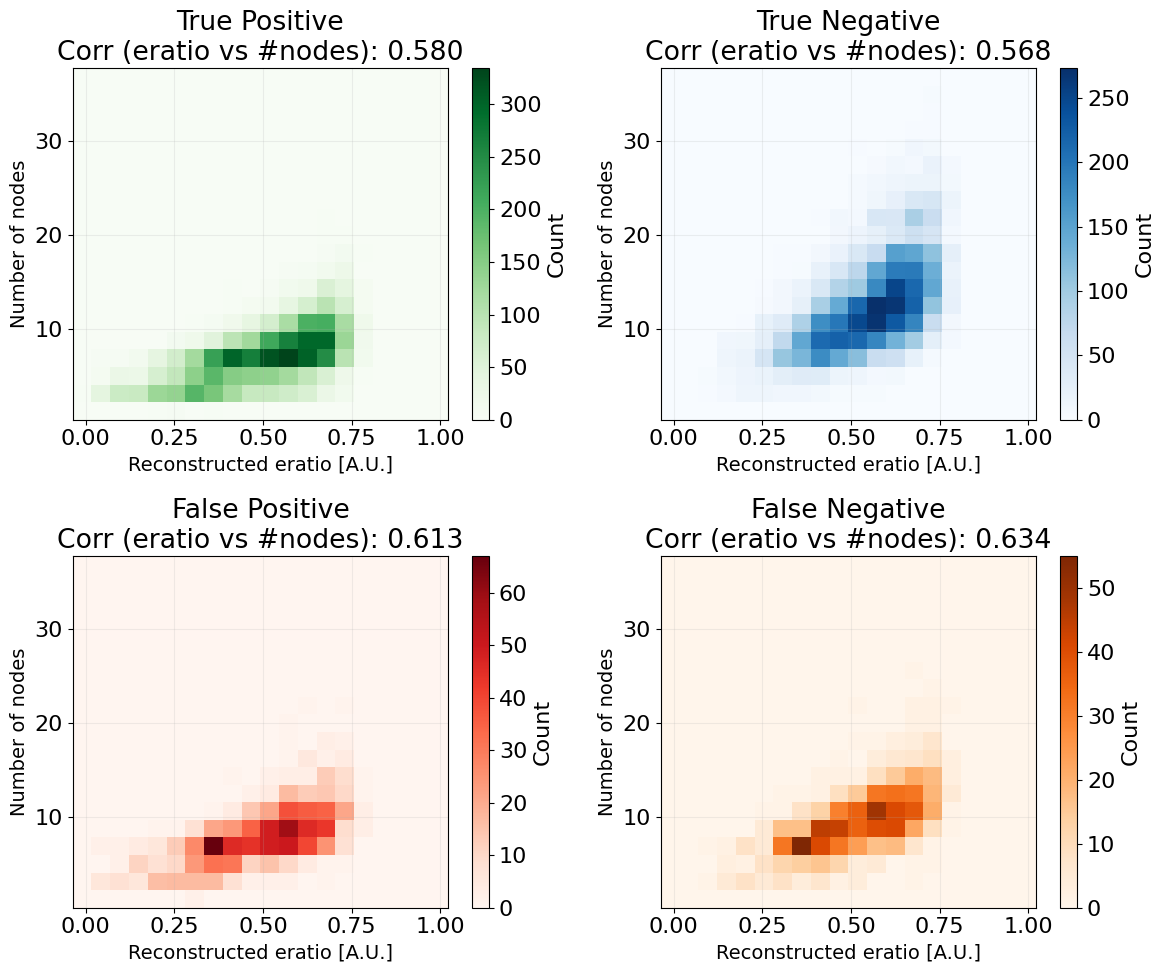

Correlation coefficients (reconstructed eratio vs number of nodes):
True Positive: 0.5796
True Negative: 0.5677
False Positive: 0.6135
False Negative: 0.6342


In [54]:
import numpy as np
import matplotlib.pyplot as plt

def collect_nodes_and_eratio(indices):
    node_counts = []
    eratios = []
    for i in indices:
        data = testset[i]
        node_counts.append(int(data.x.size(0)))
        # get reconstructed eratio
        _, eratio, _ = compute_graph_quantities(data.x)  # adjust to output eratio
        try:
            eratio_val = float(eratio)
        except Exception:
            eratio_val = np.asarray(eratio).item()
        eratios.append(eratio_val)
    return np.array(eratios), np.array(node_counts)

# compute arrays (eratio on x, nodes on y)
eratios_TP, nodes_TP = collect_nodes_and_eratio(TP_idx)
eratios_TN, nodes_TN = collect_nodes_and_eratio(TN_idx)
eratios_FP, nodes_FP = collect_nodes_and_eratio(FP_idx)
eratios_FN, nodes_FN = collect_nodes_and_eratio(FN_idx)

outcomes = [
    (eratios_TP, nodes_TP, 'True Positive', 'Greens'),
    (eratios_TN, nodes_TN, 'True Negative', 'Blues'),
    (eratios_FP, nodes_FP, 'False Positive', 'Reds'),
    (eratios_FN, nodes_FN, 'False Negative', 'Oranges'),
]

# --- Compute global axis limits ---
all_eratios = np.concatenate([arr for arr, _, _, _ in outcomes if len(arr) > 0])
all_nodes = np.concatenate([arr for _, arr, _, _ in outcomes if len(arr) > 0])

x_min, x_max = all_eratios.min(), all_eratios.max()
y_min, y_max = all_nodes.min(), all_nodes.max()

x_pad = 0.05 * (x_max - x_min) if x_max > x_min else 1
y_pad = 0.05 * (y_max - y_min) if y_max > y_min else 1
x_min -= x_pad
x_max += x_pad
y_min -= y_pad
y_max += y_pad

# --- Plot ---
plt.figure(figsize=(12, 10))
for i, (eratios, nodes, label, cmap) in enumerate(outcomes, 1):
    plt.subplot(2, 2, i)
    if len(eratios) > 5:
        plt.hist2d(eratios, nodes, bins=[20, 20], cmap=cmap, range=[[x_min, x_max], [y_min, y_max]])
        plt.colorbar(label='Count')
    elif len(eratios) > 0:
        plt.scatter(eratios, nodes, s=30, alpha=0.6)
    else:
        plt.text(0.5, 0.5, 'No data', ha='center', va='center', transform=plt.gca().transAxes)

    # correlation (eratio vs nodes)
    if len(eratios) > 1 and np.std(eratios) > 0 and np.std(nodes) > 0:
        corr = np.corrcoef(eratios, nodes)[0, 1]
        plt.title(f'{label}\nCorr (eratio vs #nodes): {corr:.3f}')
    else:
        plt.title(label)

    plt.xlabel('Reconstructed eratio [A.U.]', fontsize=14)
    plt.ylabel('Number of nodes', fontsize=14)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig("correlation_eratio_nodes.pdf")
plt.show()

# --- Print correlation coefficients ---
print("Correlation coefficients (reconstructed eratio vs number of nodes):")
for eratios, nodes, label, _ in outcomes:
    if len(eratios) > 1 and np.std(eratios) > 0 and np.std(nodes) > 0:
        corr = np.corrcoef(eratios, nodes)[0, 1]
        print(f"{label}: {corr:.4f}")
    else:
        print(f"{label}: Not enough variance or points to compute correlation")


In [55]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Compute eratio for all layers + width ---
def compute_graph_quantities(x):
    layer = x[:, 0].long()
    energy = x[:, 3]

    total_energy = energy.sum().item() if energy.sum().item() > 0 else 1e-8  # avoid zero division

    eratios = []
    for l in range(4):
        layer_energy = energy[layer == l].sum().item()
        eratios.append(layer_energy / total_energy)

    # Width calculation (optional, same as before)
    widths = []
    for l in range(4):
        mask = (layer == l)
        coords = x[mask][:, 1:3]  # [eta, phi]
        if coords.size(0) < 2:
            continue
        diff = coords.unsqueeze(0) - coords.unsqueeze(1)
        dR = torch.norm(diff, dim=-1)
        widths.append(dR.max().item())
    width = max(widths) if widths else 0.0

    return eratios, width

# --- Collect nodes and eratios for each layer ---
def collect_nodes_and_eratios(indices):
    node_counts = []
    eratios_list = [[] for _ in range(4)]  # layer0,1,2,3
    for i in indices:
        data = testset[i]
        node_counts.append(int(data.x.size(0)))
        eratios, _ = compute_graph_quantities(data.x)
        for l in range(4):
            eratios_list[l].append(eratios[l])
    return np.array(node_counts), [np.array(arr) for arr in eratios_list]

# --- Compute arrays ---
node_TP, eratios_TP = collect_nodes_and_eratios(TP_idx)
node_TN, eratios_TN = collect_nodes_and_eratios(TN_idx)
node_FP, eratios_FP = collect_nodes_and_eratios(FP_idx)
node_FN, eratios_FN = collect_nodes_and_eratios(FN_idx)

categories = [
    ("True Positive", node_TP, eratios_TP, "Greens"),
    ("True Negative", node_TN, eratios_TN, "Blues"),
    ("False Positive", node_FP, eratios_FP, "Reds"),
    ("False Negative", node_FN, eratios_FN, "Oranges"),
]


In [59]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Compute layer-specific eratio + width ---
def compute_graph_quantities(x):
    layer = x[:, 0].long()
    energy = x[:, 3]

    total_energy = energy.sum().item() if energy.sum().item() > 0 else 1e-8

    eratios = []
    for l in range(4):
        layer_energy = energy[layer == l].sum().item()
        eratios.append(layer_energy / total_energy)

    # Count nodes per layer
    node_counts = [(layer == l).sum().item() for l in range(4)]

    return eratios, node_counts

# --- Collect layer-specific nodes and eratio ---
def collect_layer_nodes_and_eratios(indices):
    nodes_list = [[] for _ in range(4)]   # nodes per layer
    eratios_list = [[] for _ in range(4)] # eratio per layer
    for i in indices:
        data = testset[i]
        eratios, node_counts = compute_graph_quantities(data.x)
        for l in range(4):
            nodes_list[l].append(node_counts[l])
            eratios_list[l].append(eratios[l])
    return [np.array(nodes) for nodes in nodes_list], [np.array(eratios) for eratios in eratios_list]

# --- Compute arrays for all categories ---
nodes_TP, eratios_TP = collect_layer_nodes_and_eratios(TP_idx)
nodes_TN, eratios_TN = collect_layer_nodes_and_eratios(TN_idx)
nodes_FP, eratios_FP = collect_layer_nodes_and_eratios(FP_idx)
nodes_FN, eratios_FN = collect_layer_nodes_and_eratios(FN_idx)

categories = [
    ("True Positive", nodes_TP, eratios_TP, "Greens"),
    ("True Negative", nodes_TN, eratios_TN, "Blues"),
    ("False Positive", nodes_FP, eratios_FP, "Reds"),
    ("False Negative", nodes_FN, eratios_FN, "Oranges"),
]

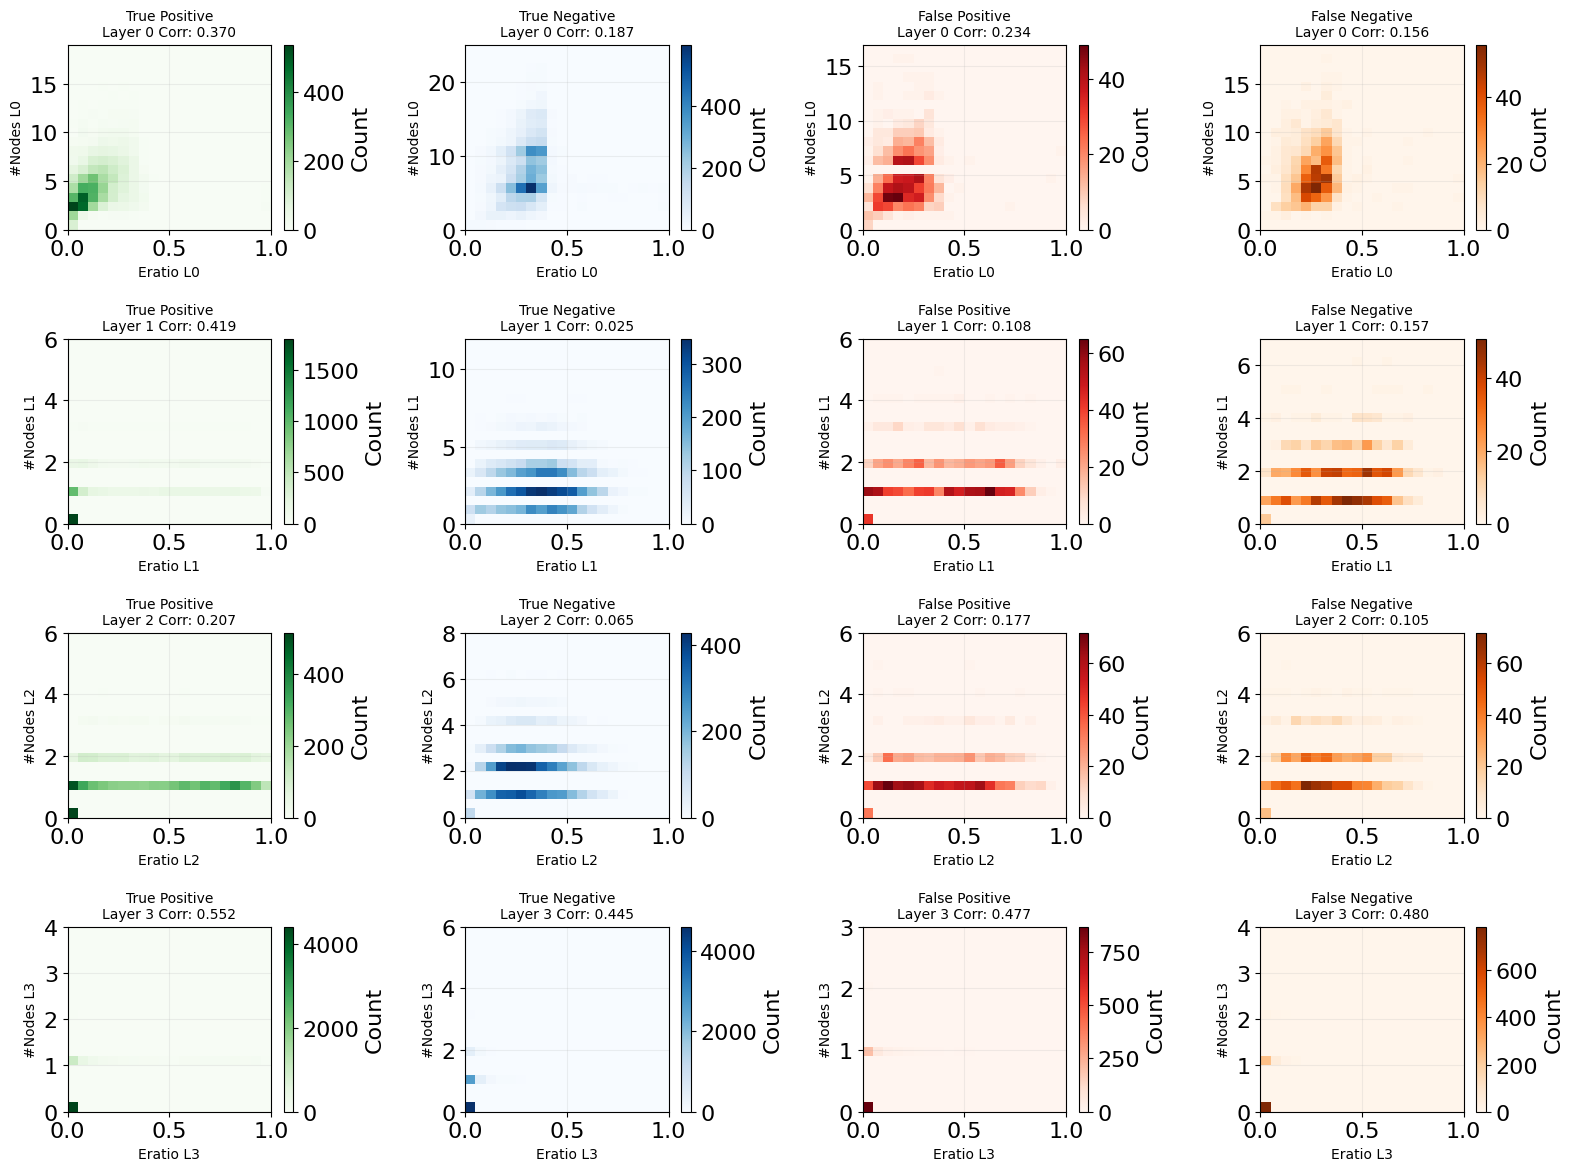

In [ ]:
plt.figure(figsize=(16, 12))
for l in range(4):
    for i, (label, nodes_layers, eratios_layers, cmap) in enumerate(categories, 1):
        plt.subplot(4, 4, l*4 + i)
        nodes = nodes_layers[l]
        eratios = eratios_layers[l]

        if len(eratios) > 5:
            plt.hist2d(eratios, nodes, bins=[20, 20], cmap=cmap, range=[[0, 1], [0, max(nodes)+1]])
            plt.colorbar(label="Count")
        elif len(eratios) > 0:
            plt.scatter(eratios, nodes, s=30, alpha=0.6)
        else:
            plt.text(0.5, 0.5, 'No data', ha='center', va='center', transform=plt.gca().transAxes)

        if len(eratios) > 1 and np.std(eratios) > 0 and np.std(nodes) > 0:
            corr = np.corrcoef(eratios, nodes)[0, 1]
            plt.title(f"{label}\nLayer {l} Corr: {corr:.3f}", fontsize=10)
        else:
            plt.title(f"{label} Layer {l}", fontsize=10)

        plt.xlabel(f"Eratio L{l}", fontsize=10)
        plt.ylabel(f"#Nodes L{l}", fontsize=10)
        plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig("eratio_vs_layer_nodes_correlation.pdf")
plt.show()

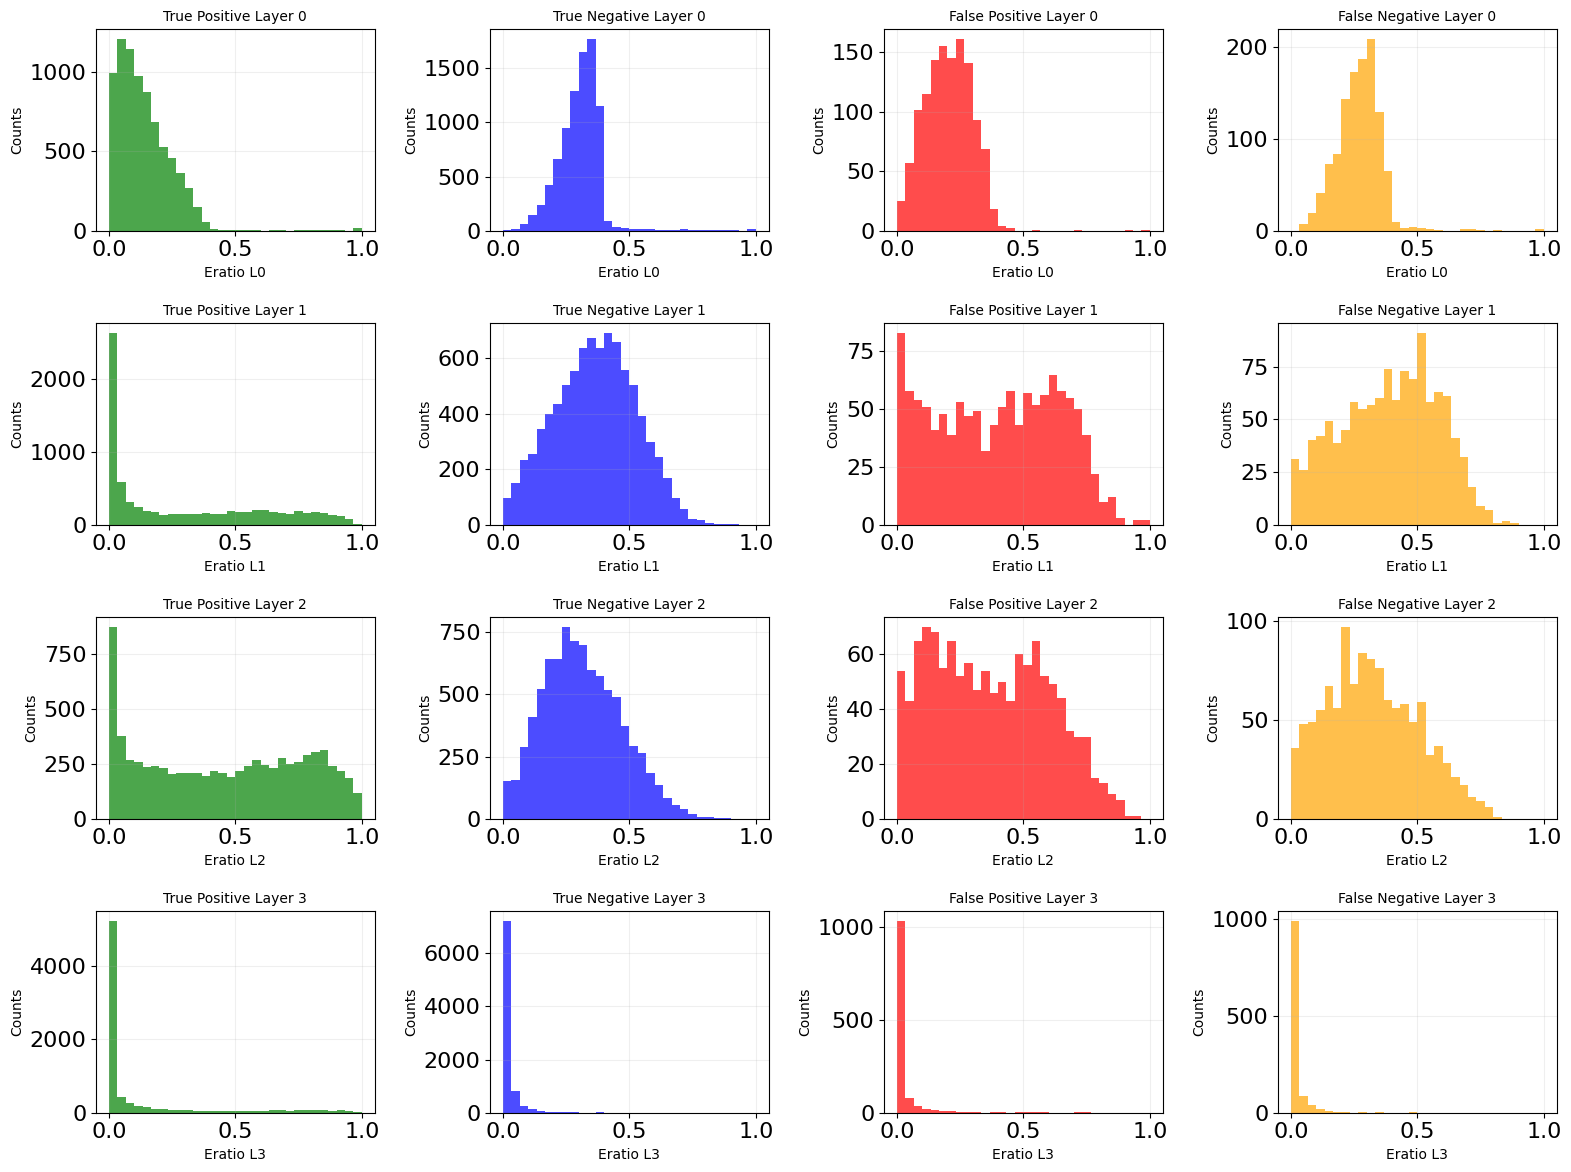

In [61]:
# --- 1D histograms per layer ---
cmap_to_color = {"Greens": "green", "Blues": "blue", "Reds": "red", "Oranges": "orange"}

plt.figure(figsize=(16, 12))
for l in range(4):
    for i, (label, nodes_layers, eratios_layers, cmap) in enumerate(categories, 1):
        plt.subplot(4, 4, l*4 + i)
        eratios = eratios_layers[l]
        color = cmap_to_color.get(cmap, "gray")
        if len(eratios) > 0:
            plt.hist(eratios, bins=30, range=(0,1), color=color, alpha=0.7)
        else:
            plt.text(0.5, 0.5, 'No data', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f"{label} Layer {l}", fontsize=10)
        plt.xlabel(f"Eratio L{l}", fontsize=10)
        plt.ylabel("Counts", fontsize=10)
        plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig("eratio_layer_histograms.pdf")
plt.show()